# Colorado Covid Counts by County for Jun 1, 2020 - Dec 31, 2021
This notebook aims to create geopandas plots of positive Covid cases.  June 1 was chosen because the entries for county name became consistant. All data was sourced from [Colorado Department of Health & Environment](https://covid19.colorado.gov/data).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import re
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime, timedelta

### Load all files from Jun2020-Dec2021 into one list called `covid_dfs`, and load county shape file with GeoPandas as `co_map`.
Note:  It is important to call `files.sort()` or else the globbed files will not be in sequential order.  Shape files were downloaded from [ColoradoView](http://coloradoview.org/colorado-gis/)

In [2]:
files = glob.glob('covid_rates/covid_jun2020_nov2021/covid19*.csv')
files.sort()

covid_dfs = []

for filename in files:
    pd.set_option('display.max_rows', None)
    df = pd.read_csv(filename)
    covid_dfs.append(df)
    

In [3]:
files[0:5]

['covid_rates/covid_jun2020_nov2021/covid19_case_summary_2020-05-31 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2020-06-01 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2020-06-02 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2020-06-03 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2020-06-04 copy.csv']

In [4]:
files[-4:]

['covid_rates/covid_jun2020_nov2021/covid19_case_summary_2021-12-28 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2021-12-29 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2021-12-30 copy.csv',
 'covid_rates/covid_jun2020_nov2021/covid19_case_summary_2021-12-31 copy.csv']

In [5]:
#Testing out regex for pulling the proper start date to make titling graphs as automatic as possible!

#files[0]

In [6]:
#my_date = re.findall(r'202.*\d', files[4])
#print(my_date[0])

In [7]:
co_map = gpd.read_file('counties_in_colorado copy/geo_export_7a259668-d326-4724-b8f2-4d6993cf912d.shp')

In [8]:
print(len(covid_dfs))

532


In [9]:
covid_dfs[0].head()

,description,attribute,metric,value
0,State Data,Statewide,Cases,26378.0
1,State Data,Statewide,Hospitalizations,4347.0
2,State Data,Statewide,Counties,60.0
3,State Data,Statewide,People Tested,183947.0
4,State Data,Statewide,Deaths Among Cases,1445.0


In [10]:
co_map.head()

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry
0,1.0,ADAMS,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9..."
1,3.0,ALAMOSA,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7..."
2,5.0,ARAPAHOE,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0,"MULTIPOLYGON (((-103.70653 39.73986, -103.7066..."
3,7.0,ARCHULETA,5257.0,12084.0,3.504795e+09,263558.683443,0.0,0.0,"POLYGON ((-107.12854 37.42287, -107.12881 37.3..."
4,11.0,BENT,1835.0,6499.0,3.990976e+09,254662.200852,0.0,0.0,"POLYGON ((-102.74208 38.26675, -102.74211 38.2..."


### Data Cleaning
Clean the covid data files as follows:
1. Create two DataFrames called `curr` and `prev` which will be used for calculation purposes in step 5.
2. Rows with the attribute "International" are removed.
3. Rows with the attribute "Note" are removed.
4. DataFrame is sliced to only include rows with cumulative county counts of Covid cases.
5. A new column is added titled `count_diff` that uses current and prior months cumulative counts to determine how many new cases occured on a given day.
6. A new column is added titled `county` that includes each county in all caps.
7. A new slice of the DataFrame is saved that drops the `description` and `attribute` columns.

A for loop is used to clean each DataFrame.  The cleaned DataFrames are appended to the empty list `covid_counts`.


In [11]:
covid_counts = []
covid_counts_maxes = []

for i in range(1, len(covid_dfs)):
    curr = covid_dfs[i][(covid_dfs[i]['description'] == 'Colorado Case Counts by County') & (covid_dfs[i]['attribute'] != "Note") & (covid_dfs[i]['attribute'] != "International")]
    prev = covid_dfs[i-1][(covid_dfs[i-1]['description'] == 'Colorado Case Counts by County') & (covid_dfs[i-1]['attribute'] != "Note") & (covid_dfs[i-1]['attribute'] != "International")]
    merged = curr.merge(prev, how='inner', on='attribute')
    merged['count_diff'] = merged['value_x'] - merged['value_y']
    merged['county'] = merged['attribute'].apply(lambda x: x.replace(" County", "").upper())
    #covid_counts.append(merged)
    #covid_counts_maxes.append(merged['count_diff'].max())
    new_merged = merged[['county', 'count_diff']]
    covid_counts.append(new_merged)
    covid_counts_maxes.append(new_merged['count_diff'].max())
    


In [12]:
print(covid_counts[0].head())
print(f'The highest report of positive cases for a county in this time frame is: {max(covid_counts_maxes)}')

      county  count_diff
0      ADAMS        33.0
1    ALAMOSA         2.0
2   ARAPAHOE        22.0
3  ARCHULETA         0.0
4       BACA         0.0
The highest report of positive cases for a county in this time frame is: 2004.0


In [13]:
covid_counts[0].head()

,county,count_diff
0,ADAMS,33.0
1,ALAMOSA,2.0
2,ARAPAHOE,22.0
3,ARCHULETA,0.0
4,BACA,0.0


### Merging Covid Case Counts with County Shape Data
A for loop combines the county shape data with each Covid case count DataFrame.  These two tables are of different types so the merged version is reassigned as a GeoDataFrame and stored in the list `shp_cv_list`.

#### Code Notes:
Four additional columns are added to this merged DataFrame for normilization and titling purposes.  The column `perc_pop_pos` provides the percent of the population that tested positive for Covid each day.  This population is based on 2010 Census data.  The column `stand_count` displays the standardized values of positive cases, and the column `norm_count` displays the normalized positive-case counts.  Since the distribution is not Gausian and the counts have a large range with much variability, I decided to create another column titled `log_norm_count` that represents the logarithm of the count data; the graph represents the log-normalized counts.  The final column is the `date` column.  It contains a string representation of the date for the presented data.  This column will be used to title the plots generated by GeoPandas.

Note<sub>1</sub>:  The regex method `findall` is used to pull the date of the second file from the files list (since the first file is only used to determine the count of the true first day of the sequence).  `start_date` usind indexing to pull that string date from the resulting list object.  `datetime.strptime` is used to covert the `date` string into a date object.  The `j` iterator in the for loop is used to pull the appropriate date from the `files` list each iteration resulting in the correct date for the `date` column.  This value is reformatted using `datetime.strftime` so that it displays the format `Full_Month_Name dd, YYYY` (respectively).

Note<sub>2</sub>:  Some of the `count_diff` values were negative (possibly due to improper reporting).  Since the negative values were never less than 3 or 4, I adjusted all negative `count_diff`s to 0.

In [14]:
shp_cv_list = []
perc_max_list = []

norm = MinMaxScaler()


for j in range(len(covid_counts)):  
    date_from_files = re.findall(r'202[01]-.*\d', files[j+1])
    date = datetime.strptime(date_from_files[0], '%Y-%m-%d').date()
    
    df_merged = co_map.merge(covid_counts[j], how='inner', on='county')
    df_merged['perc_pop_pos'] = (df_merged['count_diff'] / df_merged['pop_2010']) * 100
    df_merged['count_diff'] = df_merged['count_diff'].apply(lambda x: 0 if x < 0 else x)
    count_diff_array = df_merged['count_diff'].to_numpy()
    count_diff_reshaped = count_diff_array.reshape(-1, 1)
    df_merged['norm_count'] = norm.fit_transform(count_diff_reshaped)
    df_merged['log_norm_count'] = np.log(df_merged['count_diff'] + 1)
    df_merged['date'] = date.strftime('%B %d, %Y')
    perc_max_list.append(df_merged['perc_pop_pos'].max())
    geo_df = gpd.GeoDataFrame(df_merged)
    shp_cv_list.append(geo_df)

In [15]:
print(len(shp_cv_list))

531


In [16]:
shp_cv_list[12].head()

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry,count_diff,perc_pop_pos,norm_count,log_norm_count,date
0,1.0,ADAMS,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9...",31.0,0.007020,0.704545,3.465736,"June 13, 2020"
1,3.0,ALAMOSA,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7...",2.0,0.012949,0.045455,1.098612,"June 13, 2020"
2,5.0,ARAPAHOE,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0,"MULTIPOLYGON (((-103.70653 39.73986, -103.7066...",34.0,0.005944,0.772727,3.555348,"June 13, 2020"
3,7.0,ARCHULETA,5257.0,12084.0,3.504795e+09,263558.683443,0.0,0.0,"POLYGON ((-107.12854 37.42287, -107.12881 37.3...",0.0,0.000000,0.000000,0.000000,"June 13, 2020"
4,11.0,BENT,1835.0,6499.0,3.990976e+09,254662.200852,0.0,0.0,"POLYGON ((-102.74208 38.26675, -102.74211 38.2...",0.0,0.000000,0.000000,0.000000,"June 13, 2020"


# GeoPandas Plots of Colorado County Data
The maps below display log-normalized new cases reported by each county on a daily basis from June 1, 2020 - December 31, 2021.

#### Practice Map - Oct 18, 2021

<AxesSubplot:title={'center':'Colorado COVID Case Count by County June 2020 - December 2021\nOctober 18, 2021'}>

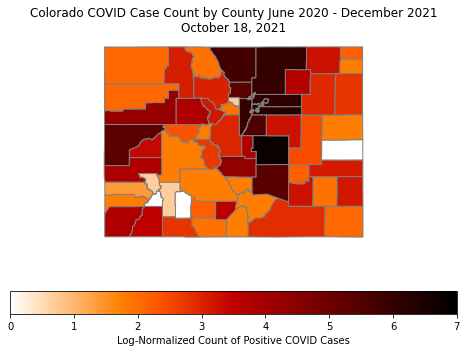

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
plt.title(f"Colorado COVID Case Count by County June 2020 - December 2021\n{shp_cv_list[476].date[0]}")
ax.set_axis_off()
shp_cv_list[476].plot(column=f'log_norm_count', 
    cmap='gist_heat_r',
    edgecolor='gray',
    vmin=0,
    vmax=7,
    ax=ax, 
    legend=True, 
    legend_kwds = {'label': f'Log-Normalized Count of Positive COVID Cases',
                    'orientation': 'horizontal'})

### 531 Geopandas Plots - One for each day between June 1, 2020 - December 31, 2021
Each plot is saved as a .jpg so that it can be uploaded in to a video editor.  All plots will be strung together to create a flipbook style video displaying changes in positive cases for each county in Colorado throughout the specified time frame.

In [21]:
for k in range(len(shp_cv_list)):
    fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
    plt.title(f"Colorado COVID Case Count by County June 2020 - December 2021\n{shp_cv_list[k].date[0]}")
    ax.set_axis_off()
    shp_cv_list[k].plot(column=f'log_norm_count', 
        cmap='gist_heat_r',
        edgecolor='gray',
        vmin=0,
        vmax=7,
        ax=ax, 
        legend=True, 
        legend_kwds = {'label': f'Log-Normalized Count of Positive COVID Cases',
                        'orientation': 'horizontal'})
    plt.savefig(f'log_norm_covid_count_by_county_jun_dec{k}.jpg')
    plt.close()